# Práctica NLP
Hecha por Rubén Cerezo Cuesta
En esta práctica, vamos a hacer dos modelos de NLP a partir de un dataset de Amazon formado por reseñas de videojuegos. Con esto, esperamos conseguir un análisis de sentimiento. Tras entrenar estos modelos, podremos conseguir una herramienta que catalogue reviews en función de cómo de positivas son. 
Este trabajo está dividido en 4 fases:
- **Exploración de datos**
- Preprocesamiento de datos
- división Train/Test y entrenamiento
- Métricas y conclusiones
En este caso, el corpus elegido, de Amazon, incluye reviews de videojuegos, simplemente por ser un tema que conozco y que he pensado que podría resultar fácil a la hora de reconocer el producto con el que trabajo. 

## Análisis exploratorio
En este primer acercamiento a los datos, nuestro objetivo será: 
- Descargar los datos como un dataset.
- Seleccionamos de este corpus 1000 reseñas asociadas a una puntuación para así tener un dataset balanceado
- Analizarlos y comprobar qué columnas queremos conservar.
- Visualizar los datos para así comprobar qué preprocesamiento sería positivo para mejorar la precisión de nuestro modelo en el siguiente paso

In [2]:
import sys
print(sys.version)
sys.executable

3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


'c:\\Users\\rammu\\Documents\\projects\\NLP_04\\Scripts\\python.exe'

In [27]:
#Instalamos en nuestro venv las librerías necesarias para la práctica
!pip install --upgrade pip setuptools wheel
!pip install  scikit-learn pandas matplotlib seaborn
!pip install jupyterlab
!pip install wget
!pip install spacy==3.7.2
!pip install gensim
!pip install sklearn.manifold
#instalamos también el modelo de lenguaje spacy en inglés
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl


ERROR: Could not find a version that satisfies the requirement sklearn.manifold (from versions: none)
ERROR: No matching distribution found for sklearn.manifold


     ---------------------------------------- 0.0/400.7 MB ? eta -:--:--
     ---------------------------------------- 0.8/400.7 MB 6.7 MB/s eta 0:01:00
     ---------------------------------------- 2.4/400.7 MB 7.5 MB/s eta 0:00:54
     ---------------------------------------- 3.7/400.7 MB 7.0 MB/s eta 0:00:57
     ---------------------------------------- 5.0/400.7 MB 6.7 MB/s eta 0:00:59
      --------------------------------------- 6.0/400.7 MB 6.5 MB/s eta 0:01:01
      --------------------------------------- 7.6/400.7 MB 6.6 MB/s eta 0:01:00
      --------------------------------------- 8.9/400.7 MB 6.7 MB/s eta 0:00:59
     - ------------------------------------- 10.5/400.7 MB 6.7 MB/s eta 0:00:58
     - ------------------------------------- 12.1/400.7 MB 6.8 MB/s eta 0:00:58
     - ------------------------------------- 13.1/400.7 MB 6.6 MB/s eta 0:00:59
     - ------------------------------------- 14.7/400.7 MB 6.7 MB/s eta 0:00:58
     - ------------------------------------- 16

In [4]:
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.8.0/en_core_web_lg-3.8.0-py3-none-any.whl (400.7 MB)


In [5]:
#En primer lugar, descargamos el dataset y lo cargamos en un dataframe de pandas
import pandas as pd
import wget
link = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz"
path = r"C:\Users\rammu\Documents\projects\NLP_04\práctica\dataset\reviews_Video_Games_5.json.gz"
wget.download(link, path)


'C:\\Users\\rammu\\Documents\\projects\\NLP_04\\práctica\\dataset\\reviews_Video_Games_5.json.gz'

In [6]:
#Cargamos el dataset en un dataframe de pandas (usamos una celda aparte para no tener que descargar el dataset cada vez)
df = pd.read_json(path, lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2HD75EMZR8QLN,0700099867,123,"[8, 12]",Installing the game was a struggle (because of...,1,Pay to unlock content? I don't think so.,1341792000,"07 9, 2012"
1,A3UR8NLLY1ZHCX,0700099867,"Alejandro Henao ""Electronic Junky""","[0, 0]",If you like rally cars get this game you will ...,4,Good rally game,1372550400,"06 30, 2013"
2,A1INA0F5CWW3J4,0700099867,"Amazon Shopper ""Mr.Repsol""","[0, 0]",1st shipment received a book instead of the ga...,1,Wrong key,1403913600,"06 28, 2014"
3,A1DLMTOTHQ4AST,0700099867,ampgreen,"[7, 10]","I got this version instead of the PS3 version,...",3,"awesome game, if it did not crash frequently !!",1315958400,"09 14, 2011"
4,A361M14PU2GUEG,0700099867,"Angry Ryan ""Ryan A. Forrest""","[2, 2]",I had Dirt 2 on Xbox 360 and it was an okay ga...,4,DIRT 3,1308009600,"06 14, 2011"


In [7]:
#visualizamos los valores distintos de la columna 'overall' para ver los posibles estados de ánimo
df['overall'].value_counts()

overall
5    120185
4     54804
3     28275
1     14853
2     13663
Name: count, dtype: int64

In [8]:
#guardamos 1000 muestras aleatorias de cada estado de ánimo en un nuevo dataframe para balancear las clases
df_1 = df[df['overall'] == 1].sample(n=1000, random_state=42)
df_2 = df[df['overall'] == 2].sample(n=1000, random_state=42)
df_3 = df[df['overall'] == 3].sample(n=1000, random_state=42)
df_4 = df[df['overall'] == 4].sample(n=1000, random_state=42)
df_5 = df[df['overall'] == 5].sample(n=1000, random_state=42)
df_balanced = pd.concat([df_1, df_2, df_3, df_4, df_5])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['overall'].value_counts()
df_balanced.to_csv(path, index=False)
#guardamos en un archivo csv el dataframe balanceado
df_balanced.to_csv("reviews_Video_Games_5_balanced.csv", index=False)
#cargamos el dataframe balanceado
df_balanced = pd.read_csv("reviews_Video_Games_5_balanced.csv")
df_balanced.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3DLWSSO2LVC1E,B000FDOTIQ,Kora,"[4, 6]",Final Fantasy VII for the ps1 was (and still i...,2,More like a movie than a game.,1164844800,"11 30, 2006"
1,AJIDIVBILJKO0,B002DY9KHU,MekoRush,"[0, 0]",Yeah it's ok. it was easy to get use to the co...,3,"Sneakly reviewing this game, it's ok",1334534400,"04 16, 2012"
2,A3PZ4AXTY9J1DZ,B000R39GPA,Jason Ralsky,"[2, 2]",Star Wars: The Force Unleashed (SW:TFU) at lau...,3,Misses the mark of past Jedi games just barely,1287964800,"10 25, 2010"
3,AW3BDUZUFZMFX,B0000A92KZ,Joshua T. Garcia,"[1, 2]",This review may contain minor spoilers. It was...,2,The Fall of Max Payne,1318118400,"10 9, 2011"
4,A1GBZD75UNMD2B,B001TOQ8R0,"Adgear ""Derebu""","[8, 9]",I'm having the same problems as everyone else ...,1,Don't buy this game!!,1269388800,"03 24, 2010"


<Axes: xlabel='overall'>

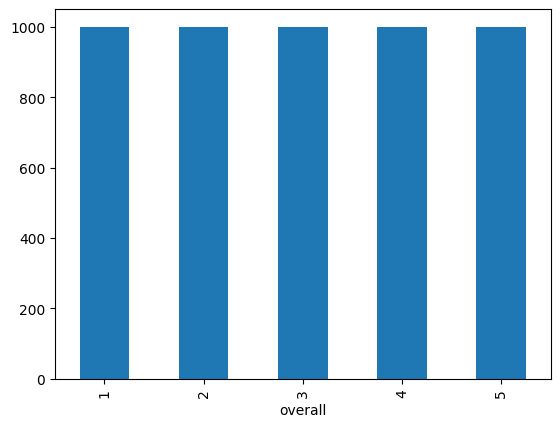

In [9]:
#Comprobamos que esté balanceado
df_balanced['overall'].value_counts().sort_index().plot(kind='bar')

## Eliminar columnas innecesarias 
Dado que tenemos un dataset "bruto" con muchas columnas que no necesitamos, vamos a comprobar qué información contiene cada una, y veremos su utilidad para después eliminarla o no.

| Columna            | Qué significa                                                                                      | Relevancia para Análisis de Sentimiento                                                      |
| ------------------ | -------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------- |
| **reviewerID**     | Identificador único del usuario que hizo la reseña.                                                |  No aporta al sentimiento.                                                                  |
| **asin**           | Identificador del producto (Amazon Standard Identification Number).                                |  No aporta al sentimiento (salvo si buscáramos hacer un análisis por producto).                                    |
| **reviewerName**   | Nombre del usuario.                                                                                |  No aporta.                                                                                 |
| **helpful**        | Lista tipo `[n_helpful_votes, total_votes]`, indica si otros usuarios consideraron útil la reseña. | No es útil
| **reviewText**     | Texto completo de la reseña.                                                                       |  **Fundamental.** Es la fuente del sentimiento.                                             |
| **overall**        | Puntuación numérica (Como ya he comprobado arriba, sólo hay puntuaciones 1-5).                                                             |  **Perfecto como etiqueta para supervisado.**                                               |
| **summary**        | Título corto de la reseña.                                                                         |  Podría complementar el reviewText ya que aporta más información, pero no lo vamos a usar en este análisis
| **unixReviewTime** | Fecha en formato UNIX.                                                                             |  No aporta al sentimiento directamente.                                                     |
| **reviewTime**     | Fecha legible.                                                                                     |  No aporta  sentimiento .                                                        |


In [10]:
#Eliminamos columnas innecesarias
df_balanced = df_balanced.drop(columns=['reviewerID', 'asin', 'reviewerName', 'helpful', 'unixReviewTime', 'reviewTime', 'summary'])
df_balanced.head()


,reviewText,overall
0,Final Fantasy VII for the ps1 was (and still i...,2
1,Yeah it's ok. it was easy to get use to the co...,3
2,Star Wars: The Force Unleashed (SW:TFU) at lau...,3
3,This review may contain minor spoilers. It was...,2
4,I'm having the same problems as everyone else ...,1


Tras mantener sólo el índice, el texto de la review y la nota, haremos un pequeño análisis estadístico para comprobar que nuestras reviews son adecuadas para un estudio. Para esto vamos a comprobar el número de nulos, si hay reviews duplicadas, y graficaremos el número de caracteres por review, de manera que podremos observar si nuestro corpus nos va a dar una idea clara (es decir, si las reviews de 5 estrellas tuvieran muy pocos caracteres, esto nos daría una muestra sesgada y no permitiría a nuestro modelo aprender las características de una review de 5 estrellas )

In [11]:
#comprobamos si hay valores nulos en el dataframe
df_balanced.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [12]:
#Comprobamos si hay reviews duplicadas
df_balanced.duplicated(subset=['reviewText']).sum()
#comprobamos ahora los tipos de datos que tenemos
df_balanced.dtypes

reviewText    object
overall        int64
dtype: object

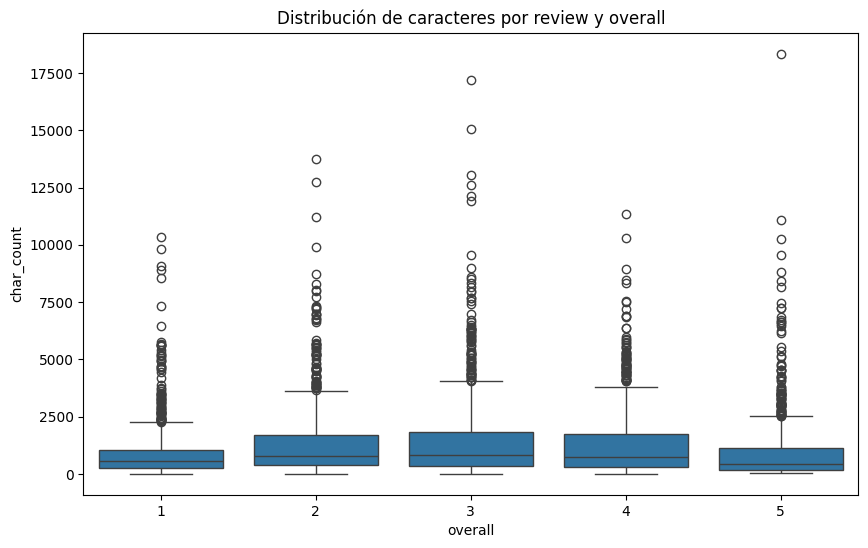

In [13]:
#comprobamos media y moda de caracteres por review y overall (cuánto se extienden las reviews según la nota)
df_balanced['char_count'] = df_balanced['reviewText'].apply(len)
df_balanced.groupby('overall')['char_count'].agg(['mean', 'median'])
#vemos la distribución de caracteres por review y overall
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
sns.boxplot(x='overall', y='char_count', data=df_balanced)
plt.title('Distribución de caracteres por review y overall')
plt.show()


In [14]:
# Comprobamos el tamaño del vocabulario bruto
raw_vocab = set(" ".join(df_balanced['reviewText']).split())
len(raw_vocab)

81552

Tras mantener sólo el índice, el texto de la review y la nota, vamos a utilizar distintas herramientas que nos ayudarán a visualizar mejor el corpus.
Para observar el dataset de una manera "entendible", vamos a hacer una serie de funciones que nos permitan entender el dataset
En primer lugar, vamos a hacer una función preprocess_text, que convierta el texto a minúsculas y elimine signos de puntuación.
Después, aplicaremos una función stop_words, que nos permitirá eliminar preposiciones, conjunciones y otras palabras con poca carga semántica
Después, vamos a crear una función top_words que nos devuelva las palabras más usadas 

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import re
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
# Cargar spaCy solo una vez y sin funciones lentas
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])

#Hacemos un pequeño preprocesamiento para poder explorar las palabras más comunes de una manera sencilla
def preprocess_text (dataset):
    """
    Esta función realiza un preprocesamiento básico del texto en la columna 'reviewText' de un dataframe de pandas.
    Convierte el texto a minúsculas y elimina los caracteres que no son letras ni números. 
    
    dataset: Es el dataset o corpus que informamos a la función. Debe contener la columna 'reviewText'
    return: El dataframe con la columna 'reviewText' preprocesada.
    """
    dataset['reviewText'] = dataset['reviewText'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.lower()))
    return dataset

#Creamos una función para quitar las stopwords utilizando la librería spacy

# Eliminar stop words

stopwords = set(STOP_WORDS)
def remove_stopwords(text):
    tokens = text.split()   # ya está limpio
    tokens = [t for t in tokens if t not in stopwords]
    return " ".join(tokens)

# convertimos todas las reviews a una lista gigante de palabras
def top_words (df, n=20):
    """
    Esta función devuelve las n palabras más comunes en un dataframe de pandas que contiene reviews de texto en una columna llamada 'reviewText'
    
    df: Es el dataset o corpus que informamos a la función. Debe contener la columna 'reviewText'
    n: Es el número de palabras más comunes que queremos obtener. Por defecto es 20, pero podemos ajustarlo a nuestro gusto.
    return: Una lista de tuplas con las n palabras más comunes y su frecuencia.
    """
    all_words = []
    for review in df['reviewText']:
        words = review.split()
        all_words.extend(words)
    # contador global
    wf = Counter(all_words)
    wf_most_common = wf.most_common(n)
    return wf_most_common

#  APLICACIÓN 
# Preprocesamos las reviews
df_balanced = preprocess_text(df_balanced)
# Quitar stopwords a TODO el corpus
df_balanced["reviewText"] = df_balanced["reviewText"].apply(remove_stopwords)

print(top_words(df_balanced, n=100))


[('game', 17376), ('like', 5177), ('games', 4205), ('play', 3316), ('time', 2710), ('good', 2704), ('fun', 2335), ('dont', 2261), ('great', 2018), ('graphics', 1826), ('playing', 1645), ('new', 1625), ('story', 1562), ('way', 1544), ('2', 1535), ('better', 1500), ('played', 1428), ('im', 1307), ('want', 1290), ('use', 1282), ('lot', 1259), ('people', 1234), ('pretty', 1225), ('little', 1189), ('bad', 1159), ('gameplay', 1147), ('3', 1119), ('buy', 1119), ('characters', 1098), ('cant', 1098), ('got', 1088), ('think', 1083), ('find', 1055), ('system', 1041), ('things', 1028), ('youre', 1020), ('different', 1002), ('character', 1000), ('level', 1000), ('thing', 1000), ('know', 999), ('right', 987), ('best', 968), ('going', 919), ('feel', 905), ('ive', 901), ('times', 898), ('doesnt', 887), ('look', 865), ('didnt', 833), ('mode', 825), ('thats', 821), ('love', 811), ('actually', 801), ('far', 797), ('player', 790), ('isnt', 785), ('need', 781), ('series', 774), ('hours', 765), ('hard', 763

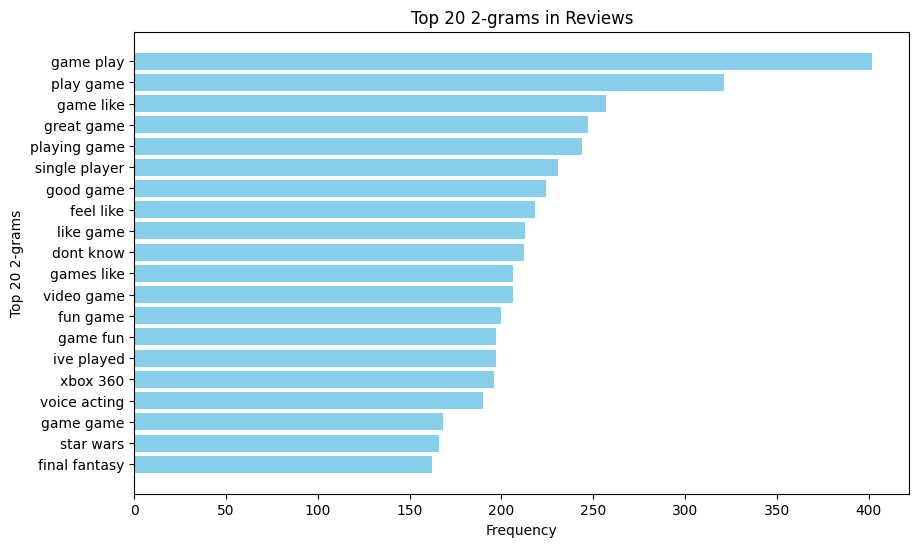

[('game play', 402), ('play game', 321), ('game like', 257), ('great game', 247), ('playing game', 244), ('single player', 231), ('good game', 224), ('feel like', 218), ('like game', 213), ('dont know', 212), ('games like', 206), ('video game', 206), ('fun game', 200), ('game fun', 197), ('ive played', 197), ('xbox 360', 196), ('voice acting', 190), ('game game', 168), ('star wars', 166), ('final fantasy', 162)]


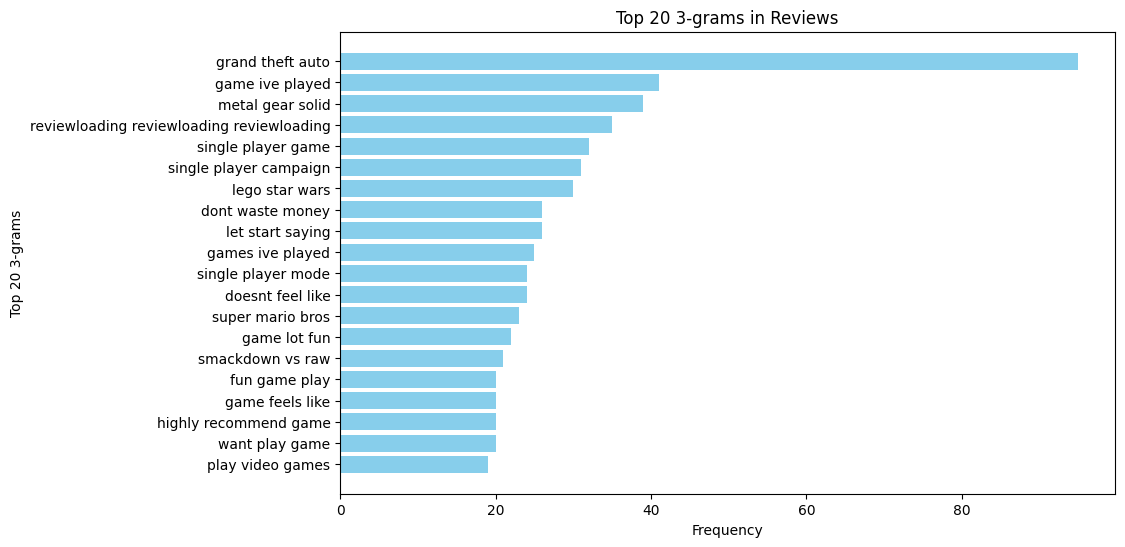

[('grand theft auto', 95), ('game ive played', 41), ('metal gear solid', 39), ('reviewloading reviewloading reviewloading', 35), ('single player game', 32), ('single player campaign', 31), ('lego star wars', 30), ('dont waste money', 26), ('let start saying', 26), ('games ive played', 25), ('single player mode', 24), ('doesnt feel like', 24), ('super mario bros', 23), ('game lot fun', 22), ('smackdown vs raw', 21), ('fun game play', 20), ('game feels like', 20), ('highly recommend game', 20), ('want play game', 20), ('play video games', 19)]


In [16]:
#Creamos una función que nos de los n-grams más comunes en el corpus, nos muestre una lista ordenada de los 20 primeros y una gráfica de barras con su frecuencia
def top_ngrams(df, n=20, ngram=2):
    """
    Esta función devuelve los n-grams más comunes en un dataframe de pandas que contiene reviews de texto en una columna llamada 'reviewText'
    
    df: Es el dataset o corpus que informamos a la función. Debe contener la columna 'reviewText'
    n: Es el número de n-grams más comunes que queremos obtener. Por defecto es 20, pero podemos ajustarlo a nuestro gusto.
    ngram: Es el tamaño del n-grama que queremos obtener. Por defecto es 2 (bigramas), pero podemos ajustarlo a nuestro gusto.
    return: Una lista de tuplas con los n-grams más comunes y su frecuencia.
    """
    all_ngrams = []
    for review in df['reviewText']:
        words = review.split()
        ngrams = zip(*[words[i:] for i in range(ngram)])
        ngrams = [' '.join(ngram) for ngram in ngrams]
        all_ngrams.extend(ngrams)
    
    # contador global
    ngram_counter = Counter(all_ngrams)
    ngram_most_common = ngram_counter.most_common(n)
    
    # Gráfica de barras
    ngram_df = pd.DataFrame(ngram_most_common, columns=['ngram', 'frequency'])
    plt.figure(figsize=(10,6))
    plt.barh(ngram_df['ngram'], ngram_df['frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel(f'Top {n} {ngram}-grams')
    plt.title(f'Top {n} {ngram}-grams in Reviews')
    plt.gca().invert_yaxis()
    plt.show()
    
    return ngram_most_common
print(top_ngrams(df_balanced, n=20, ngram=2))
print(top_ngrams(df_balanced, n=20, ngram=3))

En este análisis, encontramos que muchos de los 3-grams y 2-grams son nombres de videojuegos (Grand theft auto, Metal gear solid, Star wars, Final fantasy...)

In [17]:
#comprobamos la cardinalidad del vocabulario tras el procesamiento
processed_vocab = set(" ".join(df_balanced['reviewText']).split())
len(processed_vocab)

44938

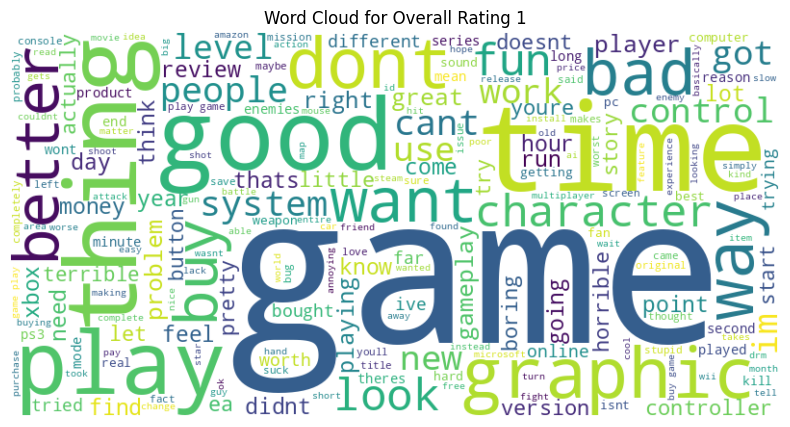

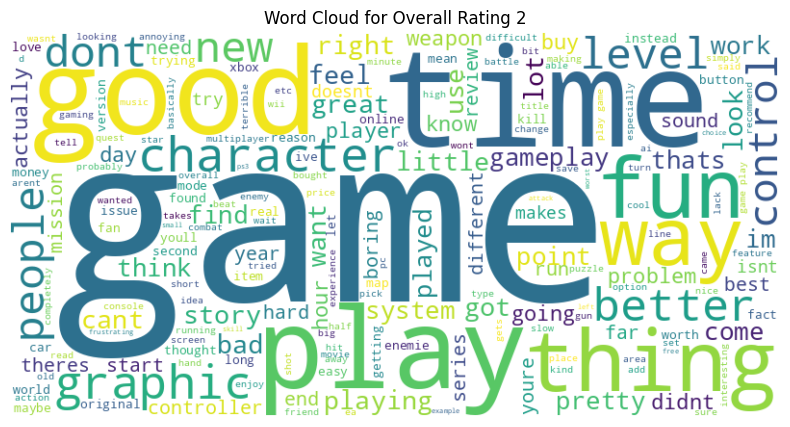

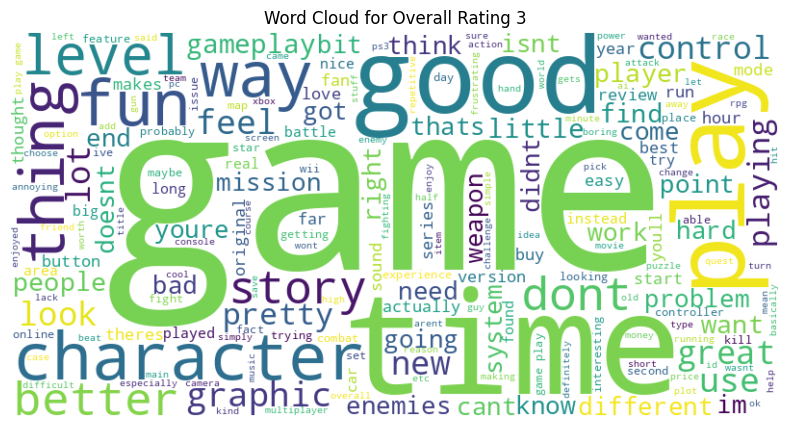

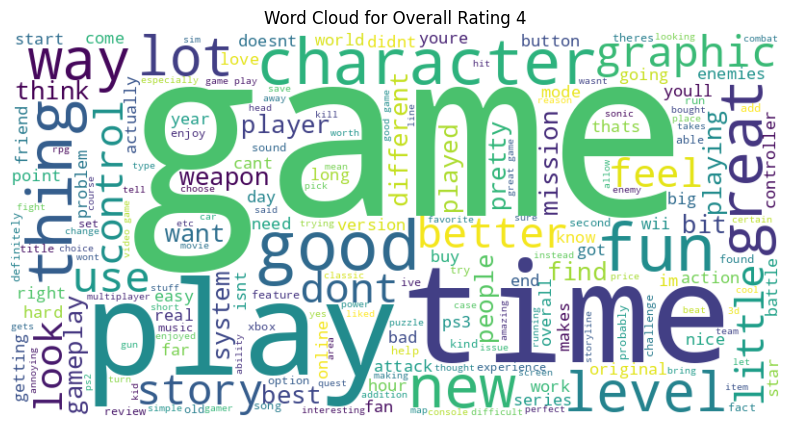

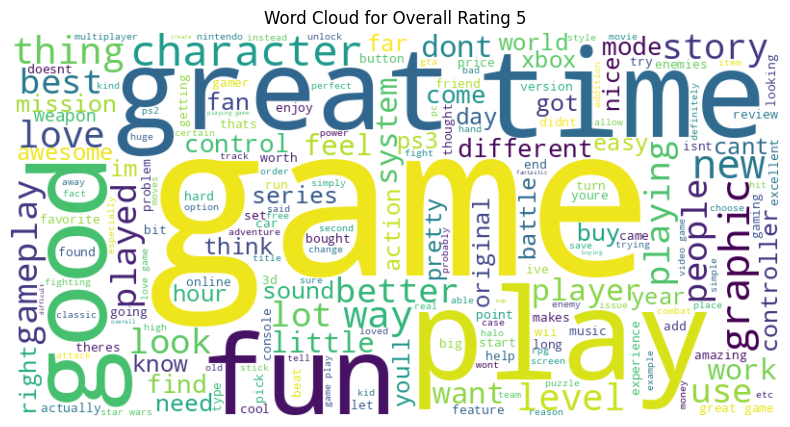

In [18]:
#También creamos una nube de palabras para cada overall. Así, veremos mejor las palabras
# más comunes en cada sentimiento
import numpy as np
from wordcloud import WordCloud
for rating in range(1, 6):
    subset = df_balanced[df_balanced['overall'] == rating]
    text = ' '.join(subset['reviewText'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Overall Rating {rating}')
    plt.show()



# Representación de word embedding

Por último, vamos a hacer 2 word embedding para comprobar cómo se representan en el espacio las palabras más  

In [19]:
#Para hacer el word2vec, primero tokenizamos las reviews
import re
import multiprocessing
from gensim.models import Word2Vec

def clean_text(text):
    return re.findall(r'\w+', text.lower())
df_balanced["tokens"] = df_balanced["reviewText"].apply(clean_text)
from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Contamos el número de cores en el ordenador
print ("el número de cores es", cores) 
# inicializamos el modelo Word2Vec y establecemos hiperparámetros
w2v_model = Word2Vec (min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)


el número de cores es 20


In [20]:
#Construimos el vocabulario
from time import time
t = time()
sent = [row.split() for row in df_balanced['reviewText']]
w2v_model.build_vocab(sent, progress_per=10000)

print('Tiempo para construir el vocabulario: {} mins'.format(round((time() - t) / 60, 2)))
print('Vocabulario compuesto por {} palabras'.format(len(w2v_model.wv.key_to_index)))



Tiempo para construir el vocabulario: 0.0 mins
Vocabulario compuesto por 3315 palabras


In [ ]:
# Comprobamos las palabras más similares a "game"
w2v_model.wv.most_similar(positive=["game"])
#Representamos estas palabras en 2D
keys = ['game','play','graphics','story']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

print(word_clusters)


[['admit', 'pretty', 'yeah', 'series', 'freedom', 'send', 'persia', 'capable', 'hold', 'route'], ['total', 'objectives', 'trigger', 'shell', 'drives', 'minute', 'ill', 'masterpiece', 'inside', 'bass'], ['man', 'depends', 'access', 'opened', 'sure', 'managed', 'michael', 'creed', 'checked', 'legend'], ['food', 'meant', 'goes', 'solution', 'beach', 'final', 'choice', 'heres', 'absolute', 'twisted']]


In [ ]:
import numpy as np
from sklearn.manifold import TSNE



tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', max_iter=3500, random_state=32)
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

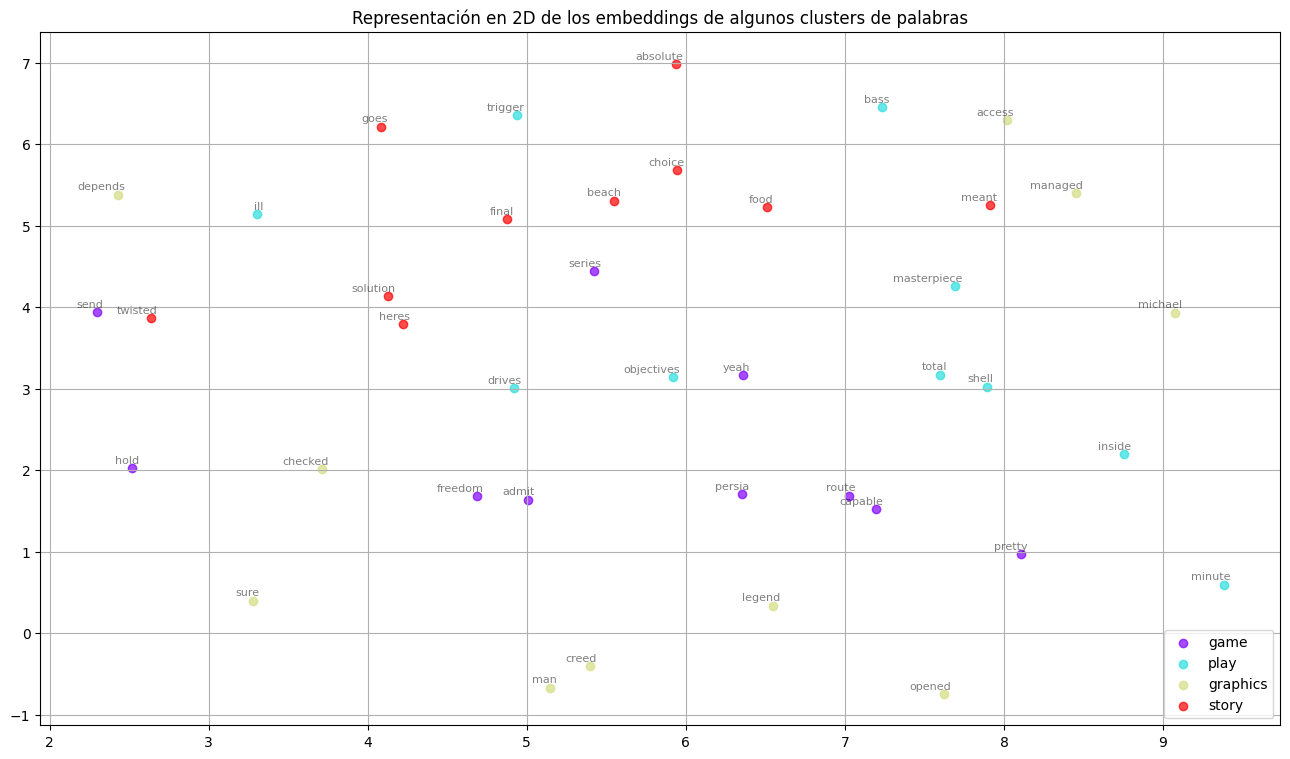

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

In [33]:
keys = ['game','play','graphics','story']
def show_similar_words(keys):
    for key in keys:
        return key, w2v_model.wv.most_similar(positive=[key])

print (show_similar_words(keys))


('game', [('admit', 0.21598899364471436), ('pretty', 0.19780312478542328), ('yeah', 0.19374993443489075), ('series', 0.18215592205524445), ('freedom', 0.18199636042118073), ('send', 0.17316538095474243), ('persia', 0.1724252849817276), ('capable', 0.17223770916461945), ('hold', 0.1701839566230774), ('route', 0.16555024683475494)])


# Conclusiones:

Tras llevar a cabo este primer acercamiento en los datos, hemos podido comprobar que:
- Los datos están balanceados, dado que artificialemnte, hemos creado un dataset con 1000 reviews de cada rating (del 1 al 5). Hemos hecho una gráfica (boxplot) del número de caracteres en cada una, y vemos que en este aspecto, son parecidas, aunque probablemente las reviews más positivas sean algo más cortas
Hemos guardado este dataset con el nombre "reviews_Video_Games_5_balanced.csv" para poder aprovecharlo en los futuros pasos de esta práctica. 
Hemos visto que el vocabulario es de 81552 palabras en bruto, antes del preprocesamiento, y 44938 después del preprocesamiento. Esto puede tener dos causas:
    - El corpus es muy pequeño, sólo de 5000 reviews
    - El corpus sólo toma datos relacionados con reviews de videojuegos, por lo que el vocabulario puede estar muy sesgado y tomar sólo palabras relacionadas con este campo semántico 
- El dataset estaba cargado de palabras que podrían no ayudar a nuestra tarea, ya que había muchas preposiciones, conjunciones, etc. Para evitar esto, hemos aplicado la función stop_words 
- los bigrams y trigrams muestran, en algunos casos, los nombres de franquicias de videojuegos. Tras repensarlo y observar algunas de las reseñas que incluyen este tipo de 